# Homework 3: Visualizing Data with Movies

Name: Johnathon Lu

Date: 2/11/2025

#### Overview
In this homework, you'll create a movie visualization of a model parameter such as temperature, salinity, velocity, or any other field which may be of interest to you. 

As an example, I've provided a movie of circulation in the Equatorial Pacific from the NASA ECCO Version 5 State Estimate. For the purposes of this visualization, I subsetted the Equatorial Pacific is the region between 155-75$^{\circ}$W and $\pm$20$^{\circ}$N.

#### Import Modules
Import the modules required to access data from netCDF files, plot it, and stitch panels together into a movie:

In [42]:
# import modules here
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cm
import moviepy.video.io.ImageSequenceClip

## Part 1: Download Data
To begin this exercise, download all of the available data for your variable of interest over the timespan of interest.

For the example provided, I've used daily sea surface temperature data for a given year (2015) from the ECCO Version 5 Alpha output [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/latlon_daily/SST.nc).

To obtain your data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes. Be sure to edit the fields to obtain the correct data.

In [43]:
# define the path to the data folder
data_folder = '/Users/johnathonlu/Documents/SJSU/cs185c_spring2025/Data'

## Part 2: Create a Single Plot of Sea Surface Temperature
Before making a movie, its useful to fine tune a single plot to get the details right. Once you've got your plot lookin' good, you can loop through all of the data to generate the panels of your movie.

Here, make a plot of one variable field. 

Begin by reading in the longitude, latitude, and SST fields from the netCDF file:

In [44]:
# read in the data
file_name = os.path.join(data_folder,'ECCO','Version5','Alpha',
                          'latlon_daily','SST','SST_20150101.nc')

# read in the sea ice data at along with the
# latitude and longitude information 
ds = xr.open_dataset(file_name, decode_times = False)
longitude = np.array(ds['LONGITUDE_T'][:])
latitude = np.array(ds['LATITUDE_T'][:])
SST = np.array(ds['SST'][:])
ds.close()

# SST (TIME, LATITUDE_T, LONGITUDE_T)

In [45]:
ds

<xarray.Dataset> Size: 4MB
Dimensions:      (TIME: 1, LATITUDE_T: 720, LONGITUDE_T: 1440)
Coordinates:
  * TIME         (TIME) float32 4B 8.402e+03
  * LATITUDE_T   (LATITUDE_T) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * LONGITUDE_T  (LONGITUDE_T) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
Data variables:
    SST          (TIME, LATITUDE_T, LONGITUDE_T) float32 4MB ...
Attributes:
    description:  ECCO LLC270 daily average

Next, find the locations of the longitude and latitude bounds within the global grid for your region of interest:

In [46]:
# define the longitude/latitude bounds
min_lon = -179.9
max_lon = 179.9
min_lat = -89.88 
max_lat = 89.88

# compute the min/max row/col in the data grid
min_row = -180
max_row = 180
min_col = -90
max_col = 90

Use the row and column bounds to subset the longitude, latitude, and your variable:

In [47]:
# subset the data
# subset sea ice to the first time step
# just have time step 0 and longitude and latitude
SST = SST[0, :, :]

Finally, make a plot with your subsetted data. For the plot specification, you can use any colormap, data range, and format as you like.

For my example, I find that the temperature plot looks nice with a figure size of (8,4), a turbo colormap, and a data range of 20-31. However, you are encouraged to format your plot to your tastes.

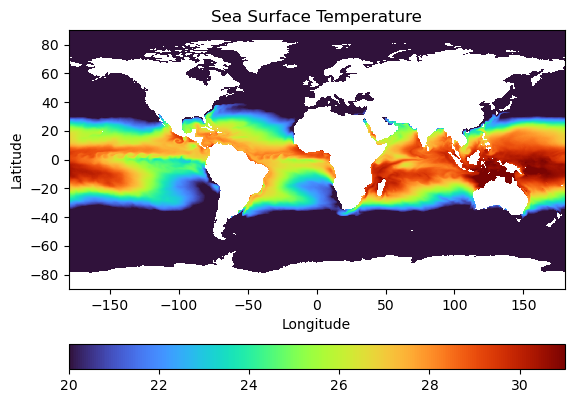

In [48]:
# make your figure here
fig = plt.figure()

# plot the temperature
plt.pcolormesh(longitude, latitude, SST, vmin=20, vmax=31, cmap='turbo')
plt.colorbar(orientation = 'horizontal')

# format the axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Surface Temperature')
plt.show()

## Part 3: Formulate a Plotting Function
When you are happy with your plot, make your code into a function that will take the year, month, and day as inputs, and output the figure into a given directory. 

In [64]:
frames_directory = 'Frames/'

def plot_panel(year,month,day):
    # fill in your function here
    file_name = 'SST_' + '{:04d}'.format(year) + '{:02d}'.format(month) + '{:02d}'.format(day) + '.nc'
    file_path = 'SST_' + '{:04d}'.format(year) + '{:02d}'.format(month) + '{:02d}'.format(day) + '.png'
    file_path = os.path.join(frames_directory,file_path)

    # read data
    file_name = os.path.join(data_folder,'ECCO','Version5','Alpha', 'latlon_daily','SST',file_name)
    ds = xr.open_dataset(file_name, decode_times = False)
    SST = np.array(ds['SST'][:])
    ds.close()
    SST = SST [0, :, :]
    
    # plot the sea ice field
    fig = plt.figure()
    plt.pcolormesh(longitude, latitude, SST, vmin=20, vmax=31, cmap='turbo')
    plt.colorbar(orientation = 'horizontal')
    
    # format the axes
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Sea Surface Temperature')
    # plt.show()
    
    # save the figure
    plt.savefig(file_path)
    plt.close(fig)

In [65]:
plot_panel (2015,1, 1)

Once the function is complete, use it to loop through all of the data to make a plot for each day of the year. The following lines of code will form the panels of a data visualization movie when using daily data. If you are using monthly data, update accordingly:

In [66]:
# loop through the data and make a plot for each day
year = 2015
for month in range(1,13):
    if month in [1,3,5,7,8,10,12]:
        n_days = 31
    elif month in [4,6,9,11]:
        n_days = 30
    else:
        if year%4==0:
            n_days = 29
        else:
            n_days = 28
    for day in range(1,n_days+1):
        plot_panel(year,month,day)

## Part 4: Compile Panels into a Movie
After creating all of the panels, stitch them together into a movie using moviepy:

In [70]:
# make a list of files for each movie panel
import calendar
file_list = []
for month in range(1,13):
    # find days in a month (ranges from 29-31)
    num_days = calendar.monthrange(year, month)[1]
    for day in range(1, num_days + 1):
        mo = '{:02d}'.format(month)
        dy = '{:02d}'.format(day)
        file_name = 'SST' + '_' + '2015' + mo + dy + '.png'
        file_url = frames_directory + '/' + file_name
        file_list.append(file_url)
# sort the panels



In [72]:
# set the frames per second
fps = 20

# use the ImageSequenceClip module to set up the clip
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(file_list, fps = fps)

# write the video to a file
clip.write_videofile('Sea Surface Temp Movie.mp4')

MoviePy - Building video Sea Surface Temp Movie.mp4.
MoviePy - Writing video Sea Surface Temp Movie.mp4



MoviePy - Done !
MoviePy - video ready Sea Surface Temp Movie.mp4


## Part 5: Interpret Features in the Movie
A movie gives a good visualization of the physical processes occurring in a model. Describe one feature you see in the movie and relate it to an oceanographic feature. It could be a feature discussed in class or another feature you noticed and researched on your own.

Answer: One thing you notice is that there is a section next the east of the US, South America, and Africa that are noticeably colder than the rest of other parts of the band of warm water near the equator. This is due to the fact that Gyros, specifically, the North and South Pacific and South Atlantic bring colder waters towards the band of the equator. While I do not know why, I also noticed that the band of heat rises as the months go by, hitting a peak around June - July or 2/3 of the way through the movie. 